#**TASK-** 
To predict the percentage of total cloud coverage as a percentage of the open sky for a fixed field of view at 4 horizon intervals of 30, 60, 90 and 120 minutes from a 6 hour window of historical data.

* The cloud cover value exactly equal to minus one means it's a nighttime.

* A very big negative number means there is some problem with the camera and the value could not, it is not captured at that time.

* Number between 0 to 100 is a realistic number which which, on which we expect you to train your models 

* and a number, which is greater than hundred, you can
cross reference with the image it may be outlier or it may be a useful data

* no datapoints have %cc>100
* %cc=(-1) means its night time

#**PREPROCESSING**

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
 
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision.datasets.utils import download_url 
 
# # Dowloading the dataset 
dataset_url = "https://he-public-data.s3.ap-southeast-1.amazonaws.com/shell_dataset.zip"
download_url(dataset_url, '/content/drive/MyDrive/Deep Learning /shell hackathon')


  0%|          | 0/3467218047 [00:00<?, ?it/s]

In [ ]:
!unzip  '/content/drive/MyDrive/Deep Learning /shell hackathon/shell_dataset.zip' -d '/content/drive/MyDrive/AI Solar Power Prediction'

Archive:  /content/drive/MyDrive/Deep Learning /shell hackathon/shell_dataset.zip
   creating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/test.zip  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/train.zip  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/test.csv  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/readme.txt  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/sample_submission.csv  


In [ ]:
!unzip '/content/drive/MyDrive/AI Solar Power Prediction/dataset/test.zip' -d '/content/drive/MyDrive/AI Solar Power Prediction/dataset'
!unzip '/content/drive/MyDrive/AI Solar Power Prediction/dataset/train.zip' -d '/content/drive/MyDrive/AI Solar Power Prediction/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/train/1010/1010091000.jpg  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/train/1010/1010092000.jpg  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/train/1010/1010093000.jpg  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/train/1010/1010094000.jpg  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/train/1010/1010095000.jpg  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/train/1010/1010100000.jpg  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/train/1010/1010101000.jpg  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/train/1010/1010102000.jpg  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/dataset/train/1010/1010103000.jpg  
  inflating: /content/drive/MyDrive/AI Solar Power Prediction/datas

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/AI Solar Power Prediction/dataset/train/train.csv')

In [ ]:
df

DATE (MM/DD)    MST  ...  Moisture  Albedo (CMP11)
0               1/1  00:00  ...       0.0             0.0
1               1/1  00:01  ...       0.0             0.0
2               1/1  00:02  ...       0.0             0.0
3               1/1  00:03  ...       0.0             0.0
4               1/1  00:04  ...       0.0             0.0
...             ...    ...  ...       ...             ...
527035        12/31  23:55  ...       0.0             0.0
527036        12/31  23:56  ...       0.0             0.0
527037        12/31  23:57  ...       0.0             0.0
527038        12/31  23:58  ...       0.0             0.0
527039        12/31  23:59  ...       0.0             0.0

[527040 rows x 17 columns]

In [ ]:
df[df['Total Cloud Cover [%]']<-1]

DATE (MM/DD)    MST  ...  Moisture  Albedo (CMP11)
857             1/1  14:17  ...       0.0          0.1737
858             1/1  14:18  ...       0.0          0.1751
859             1/1  14:19  ...       0.0          0.1774
2226            1/2  13:06  ...       0.0          0.2229
2227            1/2  13:07  ...       0.0          0.2230
...             ...    ...  ...       ...             ...
462703        11/17  07:43  ...       0.0          0.2952
462704        11/17  07:44  ...       0.0          0.2919
462705        11/17  07:45  ...       0.0          0.2859
462706        11/17  07:46  ...       0.0          0.2824
462707        11/17  07:47  ...       0.0          0.2829

[1529 rows x 17 columns]

In [ ]:
df['Total Cloud Cover [%]'].describe() #the negative outlier values have a huge impact on the the data that even the mean value of %cc is negative.
# So, its imp to deal with this outlier data(and these outliers cant be removed cuz its a time series model we're gonna use)

count    527040.000000
mean         -0.592061
std         432.780701
min       -7999.000000
25%          -1.000000
50%          -1.000000
75%          35.000000
max         100.000000
Name: Total Cloud Cover [%], dtype: float64

In [ ]:
df[df['Total Cloud Cover [%]']<-1]

DATE (MM/DD)    MST  ...  Moisture  Albedo (CMP11)
857             1/1  14:17  ...       0.0          0.1737
858             1/1  14:18  ...       0.0          0.1751
859             1/1  14:19  ...       0.0          0.1774
2226            1/2  13:06  ...       0.0          0.2229
2227            1/2  13:07  ...       0.0          0.2230
...             ...    ...  ...       ...             ...
462703        11/17  07:43  ...       0.0          0.2952
462704        11/17  07:44  ...       0.0          0.2919
462705        11/17  07:45  ...       0.0          0.2859
462706        11/17  07:46  ...       0.0          0.2824
462707        11/17  07:47  ...       0.0          0.2829

[1529 rows x 17 columns]

**Note that it is suitable to replace all outlier values with the closest, previous, non-outlier data bcuz the %cc at t time is significantly close to %cc at time closest and previous to t**

In [ ]:
df.loc[856,'Total Cloud Cover [%]'] #%cc at 1/1	14:16	

49

In [ ]:
df.loc[857,'Total Cloud Cover [%]'] #%cc at 1/1	14:17	

-7999

The above two quantities can be taken to be equal bcuz the %cc at t time is significantly close to %cc at time closest and previous to t

In [ ]:
for i in range(0,len(df)):
  if df.loc[i,'Total Cloud Cover [%]']<-1:
       j=i-1
       while df.loc[i,'Total Cloud Cover [%]']<-1:
         df.loc[i,'Total Cloud Cover [%]']=df.loc[j,'Total Cloud Cover [%]']
         j=j-1

In [ ]:
df[df['Total Cloud Cover [%]']<-1] 

Empty DataFrame
Columns: [DATE (MM/DD), MST, Global CMP22 (vent/cor) [W/m^2], Direct sNIP [W/m^2], Azimuth Angle [degrees], Tower Dry Bulb Temp [deg C], Tower Wet Bulb Temp [deg C], Tower Dew Point Temp [deg C], Tower RH [%], Total Cloud Cover [%], Peak Wind Speed @ 6ft [m/s], Avg Wind Direction @ 6ft [deg from N], Station Pressure [mBar], Precipitation (Accumulated) [mm], Snow Depth [cm], Moisture, Albedo (CMP11)]
Index: []

In [ ]:
df['Total Cloud Cover [%]'].describe()

count    527040.000000
mean         22.761436
std          34.999506
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          36.000000
max         100.000000
Name: Total Cloud Cover [%], dtype: float64

In [ ]:
df.loc[856,'Total Cloud Cover [%]']

49

In [ ]:
df.loc[857,'Total Cloud Cover [%]']

49

In [ ]:
df

DATE (MM/DD)    MST  ...  Moisture  Albedo (CMP11)
0               1/1  00:00  ...       0.0             0.0
1               1/1  00:01  ...       0.0             0.0
2               1/1  00:02  ...       0.0             0.0
3               1/1  00:03  ...       0.0             0.0
4               1/1  00:04  ...       0.0             0.0
...             ...    ...  ...       ...             ...
527035        12/31  23:55  ...       0.0             0.0
527036        12/31  23:56  ...       0.0             0.0
527037        12/31  23:57  ...       0.0             0.0
527038        12/31  23:58  ...       0.0             0.0
527039        12/31  23:59  ...       0.0             0.0

[527040 rows x 17 columns]

**NOTE- WE HAVE NOW HANDLED ALL THE OUTLIER DATA**

**Initial Inferances-** 
* No missing values in the train data
* All columns are purely numerical except 'DATE (MM/DD)' and 'MST'

**%Cloud cover is given here in the weather data. Then why the images?**
To find out if clouds are approaching mayhaps.
So, featurize the images and pass them also through the sequence-model 

(its not required to do image segmentation and find %cloud in the images) 

But wait..can we do something to figure out the centre of the cloud and which side it is moving towards(something along those lines?)...**Nah, not req. wind direction is already in weather dataset** 

**Then why have the images been given? (LETS FIRST BUILD MODELS WITHOUT THE IMAGE DATA THEN AND CHECK ACCURACY)**

#Scaling the Numeric Features
NOTE-DO NOT SCALE THE TARGET/OUTPUT FEATURE

In [ ]:
numeric_cols=['Global CMP22 (vent/cor) [W/m^2]',
 'Direct sNIP [W/m^2]',
 'Azimuth Angle [degrees]',
 'Tower Dry Bulb Temp [deg C]',
 'Tower Wet Bulb Temp [deg C]',
 'Tower Dew Point Temp [deg C]',
 'Tower RH [%]',
 'Peak Wind Speed @ 6ft [m/s]',
 'Avg Wind Direction @ 6ft [deg from N]',
 'Station Pressure [mBar]',
 'Precipitation (Accumulated) [mm]',
 'Snow Depth [cm]',
 'Moisture',
 'Albedo (CMP11)']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[numeric_cols])
df[numeric_cols] = scaler.transform(df[numeric_cols])

In [ ]:
df.describe()

Global CMP22 (vent/cor) [W/m^2]  ...  Albedo (CMP11)
count                    527040.000000  ...   527040.000000
mean                          0.140738  ...        0.065987
std                           0.202744  ...        0.093042
min                           0.000000  ...        0.000000
25%                           0.002552  ...        0.000000
50%                           0.006749  ...        0.000000
75%                           0.237553  ...        0.101800
max                           1.000000  ...        1.000000

[8 rows x 15 columns]

#Feature Engineering

Date:
First, let's extract different parts of the date.

In [ ]:
#assuming year to be 2019 (to extract week number of the year for every date)
#df['DATE (MM/DD)']=df['DATE (MM/DD)']+['/2019' for i in range(len(df)) ]

In [ ]:
#converting the date to mm-dd-yyyy format
#df['DATE (MM/DD)'] = df['DATE (MM/DD)'].replace('/','-', regex=True)

In [ ]:
#converting the date to yyyy-mm-dd format
#for i in range(len(df)):
#  df['Date']=df['DATE (MM/DD)'][6:10]+df['DATE (MM/DD)'][0:2]+df['DATE (MM/DD)'][3:5] 
#  print(i)

In [ ]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='ignore')
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [ ]:
#split_date(df)

Extracting the %CC at the 4 horizons for every minute:

In [ ]:
for i in range(0,(len(df)-120)):
     df.loc[i,'Total Cloud Cover [%] at t+30']=df.loc[i+30,'Total Cloud Cover [%]']
     df.loc[i,'Total Cloud Cover [%] at t+60']=df.loc[i+60,'Total Cloud Cover [%]']
     df.loc[i,'Total Cloud Cover [%] at t+90']=df.loc[i+90,'Total Cloud Cover [%]']
     df.loc[i,'Total Cloud Cover [%] at t+120']=df.loc[i+120,'Total Cloud Cover [%]']
     if i%1000==0:
       print(df.loc[i,'DATE (MM/DD)'])

1/1
1/1
1/2
1/3
1/3
1/4
1/5
1/5
1/6
1/7
1/7
1/8
1/9
1/10
1/10
1/11
1/12
1/12
1/13
1/14
1/14
1/15
1/16
1/16
1/17
1/18
1/19
1/19
1/20
1/21
1/21
1/22
1/23
1/23
1/24
1/25
1/26
1/26
1/27
1/28
1/28
1/29
1/30
1/30
1/31
2/1
2/1
2/2
2/3
2/4
2/4
2/5
2/6
2/6
2/7
2/8
2/8
2/9
2/10
2/10
2/11
2/12
2/13
2/13
2/14
2/15
2/15
2/16
2/17
2/17
2/18
2/19
2/20
2/20
2/21
2/22
2/22
2/23
2/24
2/24
2/25
2/26
2/26
2/27
2/28
2/29
2/29
3/1
3/2
3/2
3/3
3/4
3/4
3/5
3/6
3/6
3/7
3/8
3/9
3/9
3/10
3/11
3/11
3/12
3/13
3/13
3/14
3/15
3/16
3/16
3/17
3/18
3/18
3/19
3/20
3/20
3/21
3/22
3/22
3/23
3/24
3/25
3/25
3/26
3/27
3/27
3/28
3/29
3/29
3/30
3/31
3/31
4/1
4/2
4/3
4/3
4/4
4/5
4/5
4/6
4/7
4/7
4/8
4/9
4/10
4/10
4/11
4/12
4/12
4/13
4/14
4/14
4/15
4/16
4/16
4/17
4/18
4/19
4/19
4/20
4/21
4/21
4/22
4/23
4/23
4/24
4/25
4/25
4/26
4/27
4/28
4/28
4/29
4/30
4/30
5/1
5/2
5/2
5/3
5/4
5/5
5/5
5/6
5/7
5/7
5/8
5/9
5/9
5/10
5/11
5/11
5/12
5/13
5/14
5/14
5/15
5/16
5/16
5/17
5/18
5/18
5/19
5/20
5/20
5/21
5/22
5/23
5/23
5/24
5/25
5/25
5/26
5/27

In [ ]:
df=df[0:(len(df)-120)]

In [ ]:
df

DATE (MM/DD)  ... Total Cloud Cover [%] at t+120
0               1/1  ...                           -1.0
1               1/1  ...                           -1.0
2               1/1  ...                           -1.0
3               1/1  ...                           -1.0
4               1/1  ...                           -1.0
...             ...  ...                            ...
526915        12/31  ...                           -1.0
526916        12/31  ...                           -1.0
526917        12/31  ...                           -1.0
526918        12/31  ...                           -1.0
526919        12/31  ...                           -1.0

[526920 rows x 21 columns]

In [ ]:
df.describe()

Global CMP22 (vent/cor) [W/m^2]  ...  Total Cloud Cover [%] at t+120
count                    526920.000000  ...                   526920.000000
mean                          0.140769  ...                       22.766847
std                           0.202756  ...                       35.001654
min                           0.000000  ...                       -1.000000
25%                           0.002552  ...                       -1.000000
50%                           0.006783  ...                       -1.000000
75%                           0.237632  ...                       36.000000
max                           1.000000  ...                      100.000000

[8 rows x 19 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526920 entries, 0 to 526919
Data columns (total 21 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   DATE (MM/DD)                           526920 non-null  object 
 1   MST                                    526920 non-null  object 
 2   Global CMP22 (vent/cor) [W/m^2]        526920 non-null  float64
 3   Direct sNIP [W/m^2]                    526920 non-null  float64
 4   Azimuth Angle [degrees]                526920 non-null  float64
 5   Tower Dry Bulb Temp [deg C]            526920 non-null  float64
 6   Tower Wet Bulb Temp [deg C]            526920 non-null  float64
 7   Tower Dew Point Temp [deg C]           526920 non-null  float64
 8   Tower RH [%]                           526920 non-null  float64
 9   Total Cloud Cover [%]                  526920 non-null  int64  
 10  Peak Wind Speed @ 6ft [m/s]            526920 non-null  

In [ ]:
df.to_csv('df_FINAL.csv') #this csv has been uploaded in drive n shared 

#**START HERE**


* Read df_FINAL.csv from drive
* Run Code from here(below)

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Deep Learning /shell hackathon/df_FINAL.csv')

In [ ]:
df.head()

Unnamed: 0  ... Total Cloud Cover [%] at t+120
0           0  ...                           -1.0
1           1  ...                           -1.0
2           2  ...                           -1.0
3           3  ...                           -1.0
4           4  ...                           -1.0

[5 rows x 22 columns]

In [ ]:
df.describe()

Unnamed: 0  ...  Total Cloud Cover [%] at t+120
count  526920.000000  ...                   526920.000000
mean   263459.500000  ...                       22.766847
std    152108.846257  ...                       35.001654
min         0.000000  ...                       -1.000000
25%    131729.750000  ...                       -1.000000
50%    263459.500000  ...                       -1.000000
75%    395189.250000  ...                       36.000000
max    526919.000000  ...                      100.000000

[8 rows x 20 columns]

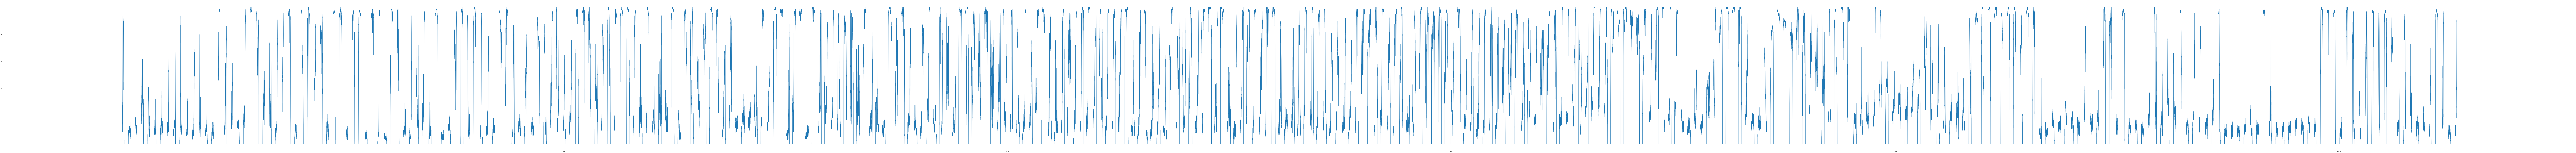

In [ ]:
df['Total Cloud Cover [%]'].plot(figsize=(500,30))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df['Total Cloud Cover [%]'],model='additive')
results.plot();

AttributeError: ignored

#Training and validation datsets

In [ ]:
# we can't randomly split the dataset as it is in sequential order 
train_df = df[:int(0.75*len(df))]
val_df = df[int(0.75*len(df)):len(df)]

In [ ]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)

train_df.shape : (395190, 22)
val_df.shape : (131730, 22)


In [ ]:
train_df.columns

Index(['Unnamed: 0', 'DATE (MM/DD)', 'MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)',
       'Total Cloud Cover [%] at t+30', 'Total Cloud Cover [%] at t+60',
       'Total Cloud Cover [%] at t+90', 'Total Cloud Cover [%] at t+120'],
      dtype='object')

In [ ]:
train_df.head()

Unnamed: 0  ... Total Cloud Cover [%] at t+120
0           0  ...                           -1.0
1           1  ...                           -1.0
2           2  ...                           -1.0
3           3  ...                           -1.0
4           4  ...                           -1.0

[5 rows x 22 columns]

#Identifying Input and Target Columns
**Input (to find %cloud cover at required time intervals):**
Weather+Image data in the past 6hrs before t.

**Target:**
 %Cloud cover at time t+30, t+60, t+90, t+120 mins.

In [ ]:
df.columns

Index(['Unnamed: 0', 'DATE (MM/DD)', 'MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)',
       'Total Cloud Cover [%] at t+30', 'Total Cloud Cover [%] at t+60',
       'Total Cloud Cover [%] at t+90', 'Total Cloud Cover [%] at t+120'],
      dtype='object')

In [ ]:
input_cols= ['Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]','Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture']

In [ ]:
output_cols=['Total Cloud Cover [%] at t+30',
       'Total Cloud Cover [%] at t+60', 'Total Cloud Cover [%] at t+90','Total Cloud Cover [%] at t+120'] 

NOTE- input for our SEQUENCE MODEL would be past 6 hours weather data and the output would be forecast of cloud cover at the 4 horizons

In [ ]:
df.loc[7,input_cols].values

array([0.006813779526377946, -1, 0.2665289256198347], dtype=object)

In [ ]:
#6HRS=6*60=360MINS
TRAIN_INPUT=[]

for i in range(360,len(df)//5):
   TRAIN_INPUT.append(df.loc[i-360:i-1,input_cols].values)
   if i%2000==0:
     print(df.loc[i,'DATE (MM/DD)'])

1/2
1/3
1/5
1/6
1/7
1/9
1/10
1/12
1/13
1/14
1/16
1/17
1/19
1/20
1/21
1/23
1/24
1/26
1/27
1/28
1/30
1/31
2/1
2/3
2/4
2/6
2/7
2/8
2/10
2/11
2/13
2/14
2/15
2/17
2/18
2/20
2/21
2/22
2/24
2/25
2/26
2/28
2/29
3/2
3/3
3/4
3/6
3/7
3/9
3/10
3/11
3/13


In [ ]:
del(df)

In [ ]:
x_train = np.array(TRAIN_INPUT)

In [ ]:
del(TRAIN_INPUT)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Deep Learning /shell hackathon/df_FINAL.csv')

In [ ]:
TRAIN_OUTPUT=[]
for i in range(360,len(df)//5): #data of %cloud cover at all 4 horizons for i-th min
   TRAIN_OUTPUT.append([df.loc[i,'Total Cloud Cover [%] at t+30'],  
                        df.loc[i,'Total Cloud Cover [%] at t+60'],
                        df.loc[i,'Total Cloud Cover [%] at t+90'],   
                        df.loc[i,'Total Cloud Cover [%] at t+120']  ])  

In [ ]:
del(df)

In [ ]:
y_train =  np.array(TRAIN_OUTPUT)

In [ ]:
del(TRAIN_OUTPUT)

In [ ]:
x_train , y_train = x_train.astype('float64'), y_train.astype('float64')

In [ ]:
x_train.shape

(30635, 360, 10)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 10, 1))
y_train = np.reshape(y_train, (y_train.shape[0] , y_train.shape[1], 1))
#x_train = torch.from_numpy(x_train)
#y_train = torch.from_numpy(y_train)
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

In [ ]:
x_train = x_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)

In [ ]:
x_train.shape

torch.Size([30635, 360, 10, 1])

In [ ]:
y_train.shape

torch.Size([30635, 4, 1])

#**MODELS:**

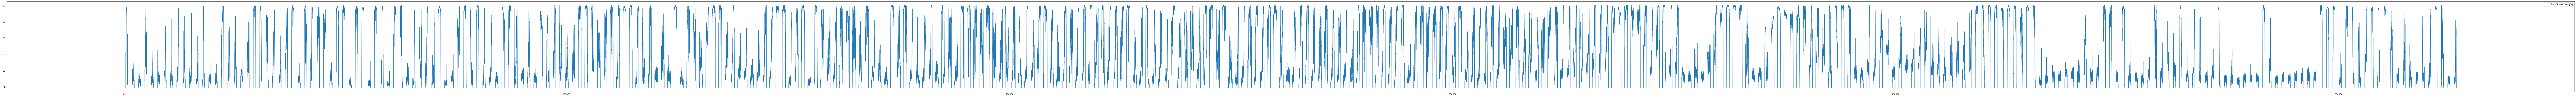

In [ ]:
df[['Total Cloud Cover [%]']].plot(figsize=(220,8))

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier()
mlp.fit(x_train,y_train)

#**ARIMA:**
You cannot use the standard implementations of ARIMA for multivariate data. For multivariate data, they are more nowcasters than forecasters because they assume you have the exogenous data at the future time points.  

In [ ]:
!pip install darts

     |████████████████████████████████| 253 kB 5.4 MB/s 
     |████████████████████████████████| 9.9 MB 33.9 MB/s 
     |████████████████████████████████| 177 kB 47.9 MB/s 
     |████████████████████████████████| 10.3 MB 28.1 MB/s 
     |████████████████████████████████| 65 kB 3.7 MB/s 
     |████████████████████████████████| 62 kB 694 kB/s 
     |████████████████████████████████| 155 kB 46.1 MB/s 
     |████████████████████████████████| 9.8 MB 35.9 MB/s 
     |████████████████████████████████| 28.5 MB 53 kB/s 
     |████████████████████████████████| 1.4 MB 34.1 MB/s 
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 788 kB 36.8 MB/s 
     |████████████████████████████████| 2.0 MB 36.3 MB/s 
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 374 kB 46.6 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 214 kB 45.6 MB/s 
  Created wheel for 

In [ ]:
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape

In [ ]:
model1=TransformerModel

In [ ]:
model1.fit([df], verbose=True)

AttributeError: ignored

#**Decision Tree:**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree = DecisionTreeRegressor()

#**LSTM:**

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
trainset = [(x_train[i], y_train[i]) for i in range(len(x_train))]
batch_size = 128
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle = True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
class LSTM1(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(10,512, batch_first = True)
    self.gate_fc = nn.Linear(512,4)
    self.fc = nn.Linear(512,4)
    self.final_fc = nn.Linear(4,4, bias = False)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    
  def forward(self,x):
    y, _ = self.lstm(x) #(N,360,15)
    out = y[:,-1,:] #(N,512)
    g = self.sigmoid(self.gate_fc(out))  # (N,4)
    ga = torch.zeros((g.shape[0],4), requires_grad=True).to(device) #(N,4)
    for batch in range(g.shape[0]):
      ga[batch,:] = torch.tensor([1 if x>0.5 else 0 for x in g[batch,:]]) #(N,4) 
    g_out = self.fc(out)  #(N,4)
    gated_out = ga*g_out  #(N,4)
    f = self.final_fc(gated_out) #(N,4)
    final_out = torch.zeros((gated_out.shape[0],4), requires_grad=True).to(device)
    for batch in range(gated_out.shape[0]):
      final_out[batch,:] = torch.tensor([-1 if x==0 else 100*self.sigmoid(x) for x in gated_out[batch,:]])
    return final_out

In [ ]:
class LSTM2(nn.Module):
  
  def __init__(self):
    
    super().__init__()
    self.lstm = nn.LSTM(10,512, batch_first = True)
    self.fc = nn.Linear(512,4)
    self.relu = nn.ReLU()

  def forward(self,x):
    out, _ = self.lstm(x)
    out = self.fc(self.relu(out[:,-1,:]))
    return out

In [ ]:
import numpy as np
best_loss = 0 



lstm_model = LSTM2()



lstm_model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 0.0001)
epochs = 10
for epoch in range(epochs):
  trainloss = []
  for idx, (x,y) in enumerate(trainloader):
    x = x.to(device)
    y = y.to(device)
    preds = lstm_model(x.squeeze(-1))
    optimizer.zero_grad()
    loss = criterion(preds, y.squeeze(-1))
    trainloss.append(loss.item())
    loss.backward()
    optimizer.step()
    if idx%250 == 0 :
      print(f'epoch:{epoch+1}({idx*100/len(trainloader)}%)\t loss: {np.mean(trainloss)}')
  if np.mean(trainloss) < best_loss:
    best_loss = np.mean(trainloss)
    torch.save(lstm_model.state_dict(), 'weights.pth')

epoch:1(0.0%)	 loss: 813.5308227539062
epoch:2(0.0%)	 loss: 592.7340087890625
epoch:3(0.0%)	 loss: 526.6427001953125
epoch:4(0.0%)	 loss: 440.9562683105469
epoch:5(0.0%)	 loss: 495.6806335449219
epoch:6(0.0%)	 loss: 330.3058166503906
epoch:7(0.0%)	 loss: 408.09661865234375
epoch:8(0.0%)	 loss: 314.6502685546875
epoch:9(0.0%)	 loss: 267.2177734375
epoch:10(0.0%)	 loss: 326.38067626953125


In [ ]:
np.mean(trainloss)

311.8288923899333

###**HYPERPARAMS TUNING:**

In [ ]:
def test_params(**params):
    model = lstm_model(random_state=42, n_jobs=-1, **params).fit(x_train, y_train)
    return model.score(X_train, train_targets), model.score(x_val, y_val)

#**MAKING PREDICTIONS**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
output=pd.read_csv('/content/drive/MyDrive/AI Solar Power Prediction/dataset/test.csv')

In [ ]:
test_df.columns

In [ ]:
for m in range(1,301):
 path= '/content/drive/MyDrive/AI Solar Power Prediction/dataset/test/' + str(m) + '/weather_data.csv'
 test_df= pd.read_csv(path)

 for i in test_df.index:
  if test_df.loc[i,'Total Cloud Cover [%]']<-1:
       j=i-1
       while test_df.loc[i,'Total Cloud Cover [%]']<-1:
         if j<0:
           k=i+1
           while test_df.loc[i,'Total Cloud Cover [%]']<-1:
               test_df.loc[i,'Total Cloud Cover [%]']=test_df.loc[k,'Total Cloud Cover [%]']
               k=k+1
         else:
          test_df.loc[i,'Total Cloud Cover [%]']=test_df.loc[j,'Total Cloud Cover [%]']
          j=j-1

 test_df=test_df.loc[1:,input_cols]

 scaler = MinMaxScaler()
 scaler.fit(test_df[test_df.columns])
 test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])


 TEST_INPUT=[]

 for k in test_df.index:
   x=test_df.loc[k,input_cols].values
   TEST_INPUT.append(x)
 x_test = np.array([TEST_INPUT])
 x_test= x_test.astype('float64')
 x_test = np.reshape(x_test, (x_test.shape[0] , x_test.shape[1], 10, 1))
 x_test = torch.tensor(x_test)
 x_test = x_test.type(torch.FloatTensor)
 x_test = x_test.to(device)


 pred = lstm_model(x_test.squeeze(-1))
 pred=pred.cpu()
 pred=pred.detach().numpy()

 output.loc[m-1,'scenario_set']=m
 output.loc[m-1,'30_min_horizon']=pred[0][0]
 output.loc[m-1,'60_min_horizon']=pred[0][1]
 output.loc[m-1,'90_min_horizon']=pred[0][2]
 output.loc[m-1,'120_min_horizon']=pred[0][3]

 print(m,end='\n')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
output

AttributeError: ignored

     scenario_set  30_min_horizon  ...  90_min_horizon  120_min_horizon
0               1        3.537063  ...        7.071161         8.310470
1               2        3.009258  ...        7.060993         8.535404
2               3        2.080961  ...        5.767927         7.159625
3               4        2.154200  ...        5.518322         6.787951
4               5        0.243787  ...        0.348676         0.413443
..            ...             ...  ...             ...              ...
295           296        1.104727  ...        4.092932         5.288098
296           297        1.601862  ...        5.361902         6.832605
297           298        1.524572  ...        5.402396         6.904457
298           299        2.481878  ...        5.996739         7.302562
299           300        1.706744  ...        5.004310         6.263913

[300 rows x 5 columns]

In [ ]:
output.describe()

AttributeError: ignored

       scenario_set  30_min_horizon  ...  90_min_horizon  120_min_horizon
count    300.000000      300.000000  ...      300.000000       300.000000
mean     150.500000        1.984870  ...        5.089914         6.252475
std       86.746758        1.009464  ...        2.065301         2.463556
min        1.000000       -0.984618  ...       -1.084843        -1.113744
25%       75.750000        1.367682  ...        4.558703         5.799480
50%      150.500000        2.084811  ...        5.518924         6.815847
75%      225.250000        2.755473  ...        6.408156         7.831517
max      300.000000        4.374300  ...        8.686198        10.154187

[8 rows x 5 columns]

In [ ]:
#output.to_csv('/content/drive/MyDrive/Deep Learning /shell hackathon/submission.csv',index=False) 
output.to_csv('Submission file.csv',index=False)

ImportError: ignored